# Flint Dataset EDA + Jared's Model

In [ ]:
#packages
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from shapely.geometry import Point,Polygon

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import precision_score, recall_score, roc_auc_score

import xgboost

### First, we will run Jared's code to recreate his model and tests

In [ ]:
# Shape files truncate column names.  This dictionary is used to restore the whole names.

col_name_dictionary = {'pid': 'pid', 'Property Z': 'Property Zip Code', 'Owner Type': 'Owner Type',
                       'Owner Stat': 'Owner State', 'Homestead': 'Homestead', 'Homestea_1': 'Homestead Percent',
                       'HomeSEV': 'HomeSEV', 'Land Value': 'Land Value', 'Land Impro': 'Land Improvements Value',
                       'Residentia': 'Residential Building Value', 'Resident_1': 'Residential Building Style',
                       'Commercial': 'Commercial Building Value', 'Building S': 'Building Storeys',
                       'Parcel Acr': 'Parcel Acres', 'Rental': 'Rental', 'Use Type': 'Use Type',
                       'Prop Class': 'Prop Class', 'Old Prop c': 'Old Prop class', 'Year Built': 'Year Built',
                       'USPS Vacan': 'USPS Vacancy', 'Zoning': 'Zoning', 'Future Lan': 'Future Landuse',
                       'DRAFT Zone': 'DRAFT Zone', 'Housing Co': 'Housing Condition 2012',
                       'Housing _1': 'Housing Condition 2014', 'Commerci_1': 'Commercial Condition 2013',
                       'Latitude': 'Latitude', 'Longitude': 'Longitude', 'Hydrant Ty': 'Hydrant Type',
                       'Ward': 'Ward', 'PRECINCT': 'PRECINCT', 'CENTRACT': 'CENTRACT', 'CENBLOCK': 'CENBLOCK',
                       'SL_Type': 'SL_Type', 'SL_Type2': 'SL_Type2', 'SL_Lead': 'SL_Lead', 'Ed_July': 'Ed_July',
                       'Ed_March': 'Ed_March', 'Last_Test': 'Last_Test', 'Max_Lead': 'Max_Lead',
                       'Med_Lead': 'Med_Lead', 'Num_Tests': 'Num_Tests', 'Res_Test': 'Res_Test',
                       'Sen_Test': 'Sen_Test', 'SL_private': 'SL_private_inspection',
                       'B_median_a': 'B_median_age_all_women', 'B_median_1': 'B_median_age_all_men', 
                       'B_median_2': 'B_median_age_all', 'B_median_3': 'B_median_age_all_women_white',
                       'B_median_4': 'B_median_age_all_men_white', 'B_median_5': 'B_median_age_all_white',
                       'B_median_6': 'B_median_age_all_women_black', 'B_median_7': 'B_median_age_all_men_black',
                       'B_median_8': 'B_median_age_all_black', 'B_total_bl': 'B_total_black_pop',
                       'B_total_wh': 'B_total_white_pop', 'B_married_': 'B_married_couples',
                       'B_single_w': 'B_single_women', 'B_marrie_1': 'B_married_couples_white',
                       'B_single_1': 'B_single_women_white', 'B_marrie_2': 'B_married_couples_black',
                       'B_single_2': 'B_single_women_black', 'B_marrie_3': 'B_married_couples_w_children',
                       'B_single_m': 'B_single_mothers_w_children', 'B_househol': 'B_households_w_elderly',
                       'B_househod': 'B_househod_no_elderly', 'B_aggregat': 'B_aggregate_income',
                       'B_speak_sp': 'B_speak_spanish', 'B_speak_on': 'B_speak_only_english',
                       'B_no_engli': 'B_no_english', 'B_hispanic': 'B_hispanic_household',
                       'B_imputed_': 'B_imputed_rent', 'B_impute_1': 'B_imputed_value',
                       'known_priv': 'known_private_sl', 'known_publ': 'known_public_sl', 'hydrovac': 'hydrovac',
                       'sl_priva_1': 'sl_private_type', 'sl_public_': 'sl_public_type', 'created_at': 'created_at',
                       'source': 'source', 'hv_visit': 'hv_visit', 'sl_visit': 'sl_visit', 'replaced': 'replaced',
                       'dangerous': 'dangerous', 'geometry': 'geometry'}

In [ ]:
# Update path to the new shapefile I sent.
sl_df = gpd.read_file('flint_sl_materials/')
sl_df = sl_df.rename(col_name_dictionary, axis=1)

In [ ]:
# Drop columns that aren't used by the classifier

drop_cols = ['known_private_sl', 'known_public_sl', 'hydrovac', 'created_at', 'source',
             'hv_visit', 'sl_visit', 'replaced', 'geometry']

data = sl_df.drop(drop_cols, axis = 1)

# Only keep labelled data
data = data[~pd.isnull(data.dangerous)].reset_index()

# Drop everything except target from training data
Xdata = data.drop(['pid', 'sl_private_type', 'sl_public_type', 'dangerous'], axis = 1)

# Build target.  Each 'dangerous' is True when sl_private_type OR sl_public_type contain lead.
Ydata = data[['sl_private_type', 'sl_public_type', 'dangerous']]


dummy_cols = ['Property Zip Code', 'Owner Type', 'Residential Building Style', 'Homestead', 'Building Storeys',
              'Rental', 'Use Type', 'Prop Class', 'Old Prop class', 'USPS Vacancy', 'Housing Condition 2012',
              'Housing Condition 2014', 'Owner State', 'Zoning', 'Future Landuse', 'Commercial Condition 2013',
              'Hydrant Type', 'SL_Type', 'SL_Type2', 'DRAFT Zone', 'Last_Test', 'SL_private_inspection', 'Ward',
              'CENTRACT', 'CENBLOCK']#, 'PRECINCT']

# Fill missing data
Xdata = Xdata.fillna(-1)

# Create dummies from categorical columns
Xdata = pd.get_dummies(Xdata, columns=dummy_cols)

# Groups for spatial cross validation
groups = Xdata['PRECINCT']
Xdata = Xdata.drop('PRECINCT', axis=1)

In [ ]:
# Group Shuffle Split example.  train_test_split could go here, but we like spatial cross validation 
# better than a uniform random sample.
gss = GroupShuffleSplit(n_splits=3, train_size=.75, random_state=42)

for train_idx, test_idx in gss.split(Xdata, Ydata, groups):
    train_index = train_idx
    test_index = test_idx
    break

Xtrain = Xdata.loc[train_index]
Xtest = Xdata.loc[test_index]
Ytrain = Ydata.loc[train_index.tolist()]
Ytest = Ydata.loc[test_index.tolist()]

In [ ]:
# Train an xgboost classifier
xgb = xgboost.XGBClassifier()

xgb.fit(Xtrain, Ytrain['dangerous'])
yhat = xgb.predict_proba(Xtest)

/root/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[01:58:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# Measure predictive power.  This is roc score, but any metric could go here.
roc_auc_score(Ytest['dangerous'], yhat[:,1])

0.9747628305396846

In [ ]:
# naive model (logistic regression with just year built as predictor)
logmodel = LogisticRegression()
logmodel.fit(Xtrain, Ytrain['dangerous'])
yhat = logmodel.predict_proba(Xtest)

# Measure predictive power.  This is roc score, but any metric could go here.
roc_auc_score(Ytest['dangerous'], yhat[:,1])

0.5965783817328624

### Now, let's explore the data.

#### Duplicate Rows and Missing Values

Before exploring the nuances of the dataset, let's get a sense of missingness in the dataset, as well as check for any duplicate parcels (by index). To do this, we re-download the data in its raw form and perform a subset of Jared's pre-processing steps:

In [ ]:
# Redownload data to have it in more raw form (before Jared's pre-processing)
sl_df = gpd.read_file('flint_sl_materials/')
sl_df = sl_df.rename(col_name_dictionary, axis=1)

# Drop columns that aren't used by the classifier
drop_cols = ['known_private_sl', 'known_public_sl', 'hydrovac', 'created_at', 'source',
             'hv_visit', 'sl_visit', 'replaced', 'geometry']
data = sl_df.drop(drop_cols, axis = 1)

# Only keep labelled target data
data = data[~pd.isnull(data.dangerous)].reset_index()

# keep everything except target in training data
Xdata = data.drop(['sl_private_type', 'sl_public_type', 'dangerous'], axis = 1)

# Build target.  Each 'dangerous' is True when sl_private_type OR sl_public_type contain lead.
Ydata = data[['sl_private_type', 'sl_public_type', 'dangerous']]

In [ ]:
Xdata.head()

,index,pid,Property Zip Code,Owner Type,Owner State,Homestead,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,...,B_single_mothers_w_children,B_households_w_elderly,B_househod_no_elderly,B_aggregate_income,B_speak_spanish,B_speak_only_english,B_no_english,B_hispanic_household,B_imputed_rent,B_imputed_value
0,38,4012482018,48503.0,Private,MI,Yes,100.0,18400,932,0,...,64,79,374,6293700.0,19,805,0,3.0,160.0,0.0
1,47,4013226009,48503.0,Private,MI,Yes,100.0,11800,420,0,...,64,79,374,6293700.0,19,805,0,3.0,160.0,0.0
2,53,4012476011,48503.0,Private,FL,No,0.0,0,602,0,...,64,79,374,6293700.0,19,805,0,3.0,160.0,0.0
3,59,4012481022,48503.0,Private,MI,Yes,50.0,4550,781,0,...,64,79,374,6293700.0,19,805,0,3.0,160.0,0.0
4,70,4013226025,48503.0,Private,MI,Yes,100.0,12800,510,0,...,64,79,374,6293700.0,19,805,0,3.0,160.0,0.0


In [ ]:
Ydata.head()

,sl_private_type,sl_public_type,dangerous
0,GALVANIZED,LEAD,1
1,GALVANIZED,LEAD,1
2,GALVANIZED,LEAD,1
3,GALVANIZED,LEAD,1
4,COPPER,LEAD,1


In [ ]:
print('Feature dimensions:', Xdata.shape)

Feature dimensions: (26863, 74)


First, we will look to see if any parcels appear more than once in our dataset. We will look for duplicate 'pid' (parcel ID):

In [ ]:
#Check that each parcel ID is unique
len(Xdata.pid.unique()) == Xdata.shape[0]

True

Great! Each parcel ID has its own row and there are no duplicates.

Now, let's explore missingness in our feature set by getting the number of missing values in each column:

In [ ]:
# Number of missing values in features
Xdata.isna().sum().sort_values(ascending=False)[0:20]

Commercial Condition 2013     26760
B_aggregate_income             4666
B_imputed_value                1500
B_imputed_rent                 1500
B_hispanic_household           1500
Housing Condition 2012          400
Residential Building Style      114
Housing Condition 2014          109
USPS Vacancy                     59
Owner State                      26
Longitude                         6
Latitude                          6
Use Type                          2
Zoning                            2
B_single_women_black              0
B_married_couples_black           0
Sen_Test                          0
SL_private_inspection             0
B_median_age_all_women            0
B_median_age_all_men              0
dtype: int64

First, let's explore why there's so much missingness in "Commerical Condition 2013." This may be because most building are residences, and residences may simply code this feature as "missing."

In [ ]:
## Values that aren't missing
Xdata['Commercial Condition 2013'].value_counts()

Good    69
Fair    32
Poor     2
Name: Commercial Condition 2013, dtype: int64

There are 103 parcels without missing data. So, let's see if this matches the number of commerical properties in the dataset:

In [ ]:
##Commerical properties in dataset
print('Use type of parcels that HAVE a 2013 commerical condition')
print(Xdata['Use Type'][Xdata['Commercial Condition 2013'].notnull().values].value_counts())

Use type of parcels that HAVE a 2013 commerical condition
Commercial     101
Residential      2
Name: Use Type, dtype: int64


So, for the most part, parcels that have 2013 commercial condition values are commerical properties. Parcels that have missing 2013 commerical condition values are residential properties. So, the missingness is really just a proxy flag for commerical or residential property.

**Ask for Jared: B_imputed column and missingness**

The "B_imputed_value", "B_imputed_rent", and "B_hispanic_household" columns each have exactly 1,500 missing values (on the same rows). Why this correspondence? Also, what does "imputed" mean in the context of the American Community Survey? Finally, why are there so many missing values for "B_aggregate_income"?


All other features have very few missing values, so we won't worry too much about them. However, one thing we should explore are the 6 missing values for longitude and lattitude, since we'll be using those features in our spatial modeling. Let's explore those missing values:

In [ ]:
##Show rows with missing longitude and latitude
Xdata[Xdata.Longitude.isna()]

,index,pid,Property Zip Code,Owner Type,Owner State,Homestead,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,...,B_single_mothers_w_children,B_households_w_elderly,B_househod_no_elderly,B_aggregate_income,B_speak_spanish,B_speak_only_english,B_no_english,B_hispanic_household,B_imputed_rent,B_imputed_value
2168,3635,4117133034,48503.0,Private,MI,Yes,100.0,49200,54915,0,...,99,283,493,33941100.0,9,972,0,24.0,85.0,195.0
13372,28281,4024477039,48507.0,Private,MI,Yes,100.0,0,4500,0,...,221,252,506,14373600.0,0,1091,0,NaN,NaN,NaN
13553,28527,4024376056,48507.0,Private,MI,Yes,100.0,0,24995,3546,...,221,252,506,14373600.0,0,1091,0,NaN,NaN,NaN
20208,42458,4129228002,48507.0,Private,MI,Yes,100.0,12300,2941,0,...,14,156,80,8657000.0,16,381,0,32.0,18.0,294.0
25503,53183,4002327049,48504.0,Private,MI,No,0.0,0,4270,0,...,54,84,143,1187600.0,0,272,0,12.0,60.0,152.0
25991,53903,4003481009,48504.0,Private,MI,Yes,100.0,11900,1850,0,...,89,208,294,712800.0,0,740,0,10.0,22.0,280.0


Upon first glance, there is nothing really distinctive about these 6 parcels (other than their missingness of Longitude and Latitude). For now, we will make note of their parcel IDs and figure out how we should handle them in construction of our spatial features.

#### Target Exploration

Let's find the proportion of "dangerous" and not dangerous homes

In [ ]:
print('Number of dangerous parcels: ',np.sum(Ydata.dangerous == '1'))
print('Proportion of parcels that are dangerous: ',np.round(np.mean(Ydata.dangerous == '1'),3))

Number of dangerous parcels:  10266
Proportion of parcels that are dangerous:  0.382


#### Quantitative Data Exploration

Let's visualize the distributions of each quantitative variable, as well as all pair-wise correlations

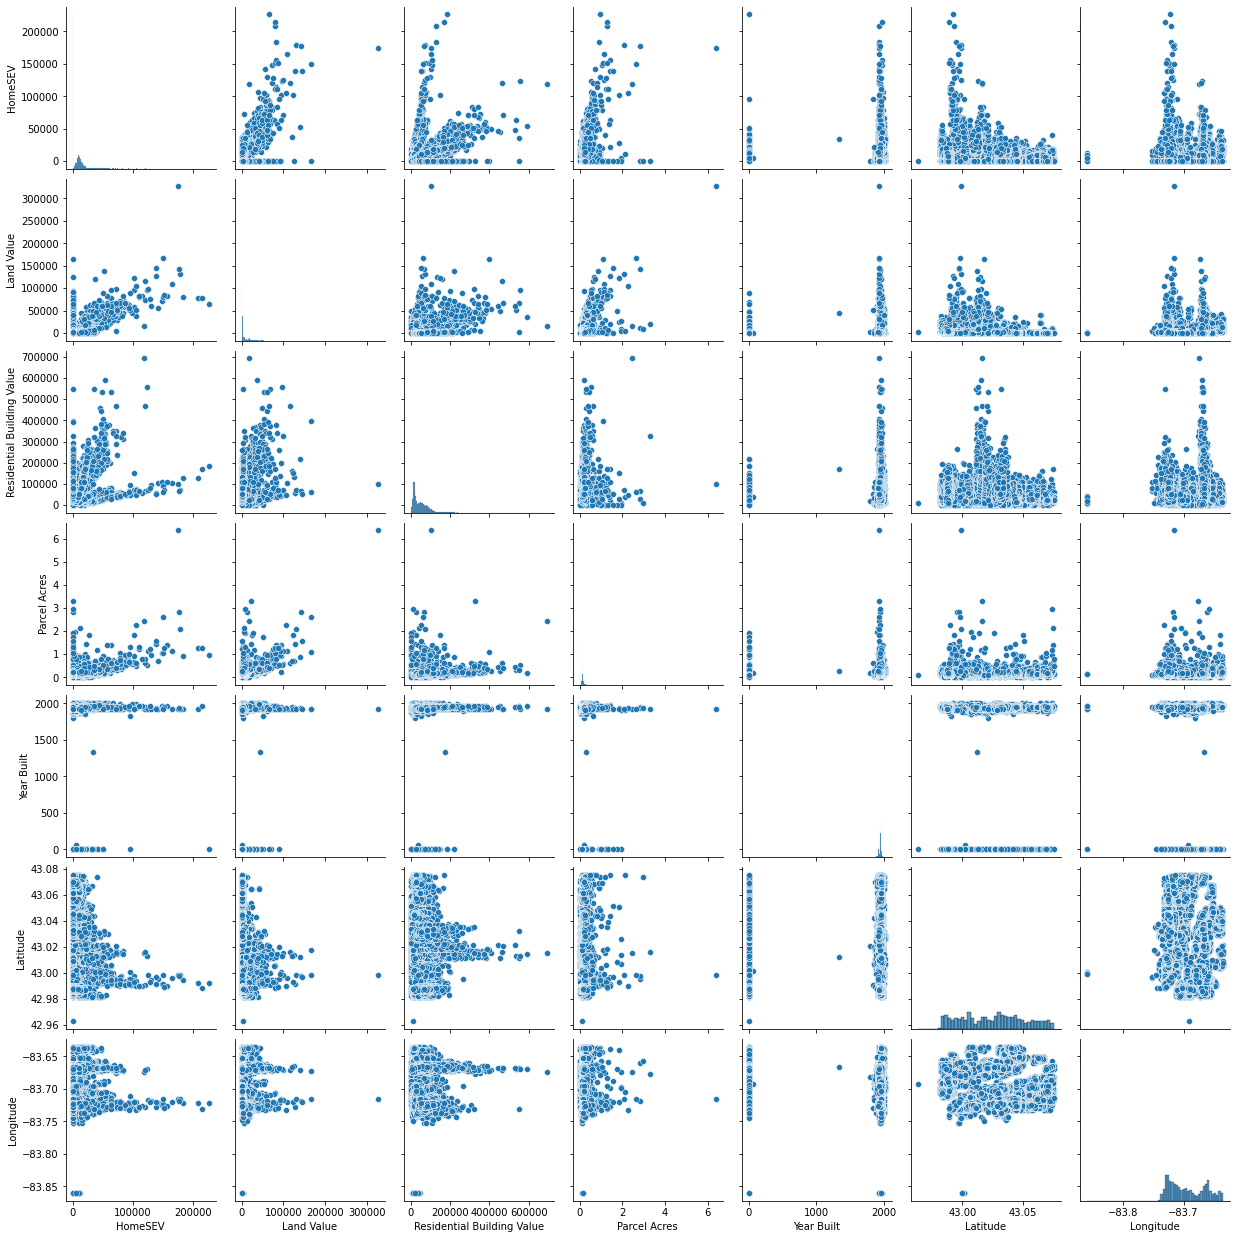

In [ ]:
#Quanitative column names
quant_features = ['HomeSEV','Land Value','Land Improvements Value','Residential Building Value',
                    'Commercial Building Value', 'Building Storeys','Parcel Acres','Year Built',
                    'Latitude','Longitude']

#features to pairplot
pairplot_features = ['HomeSEV','Land Value','Residential Building Value','Parcel Acres','Year Built',
                    'Latitude','Longitude']

#pair plot
sns.pairplot(Xdata[pairplot_features])

Variables with relatively strong positive correlations:
 - Home SEV, Land Value, Residential Building Value, Parcel Acres

This makes intuitive sense, since we would expect an association between parcel area and value, as well as between different metrics of value.

Now, let's visualize all of our quantitative variables as historgrams:

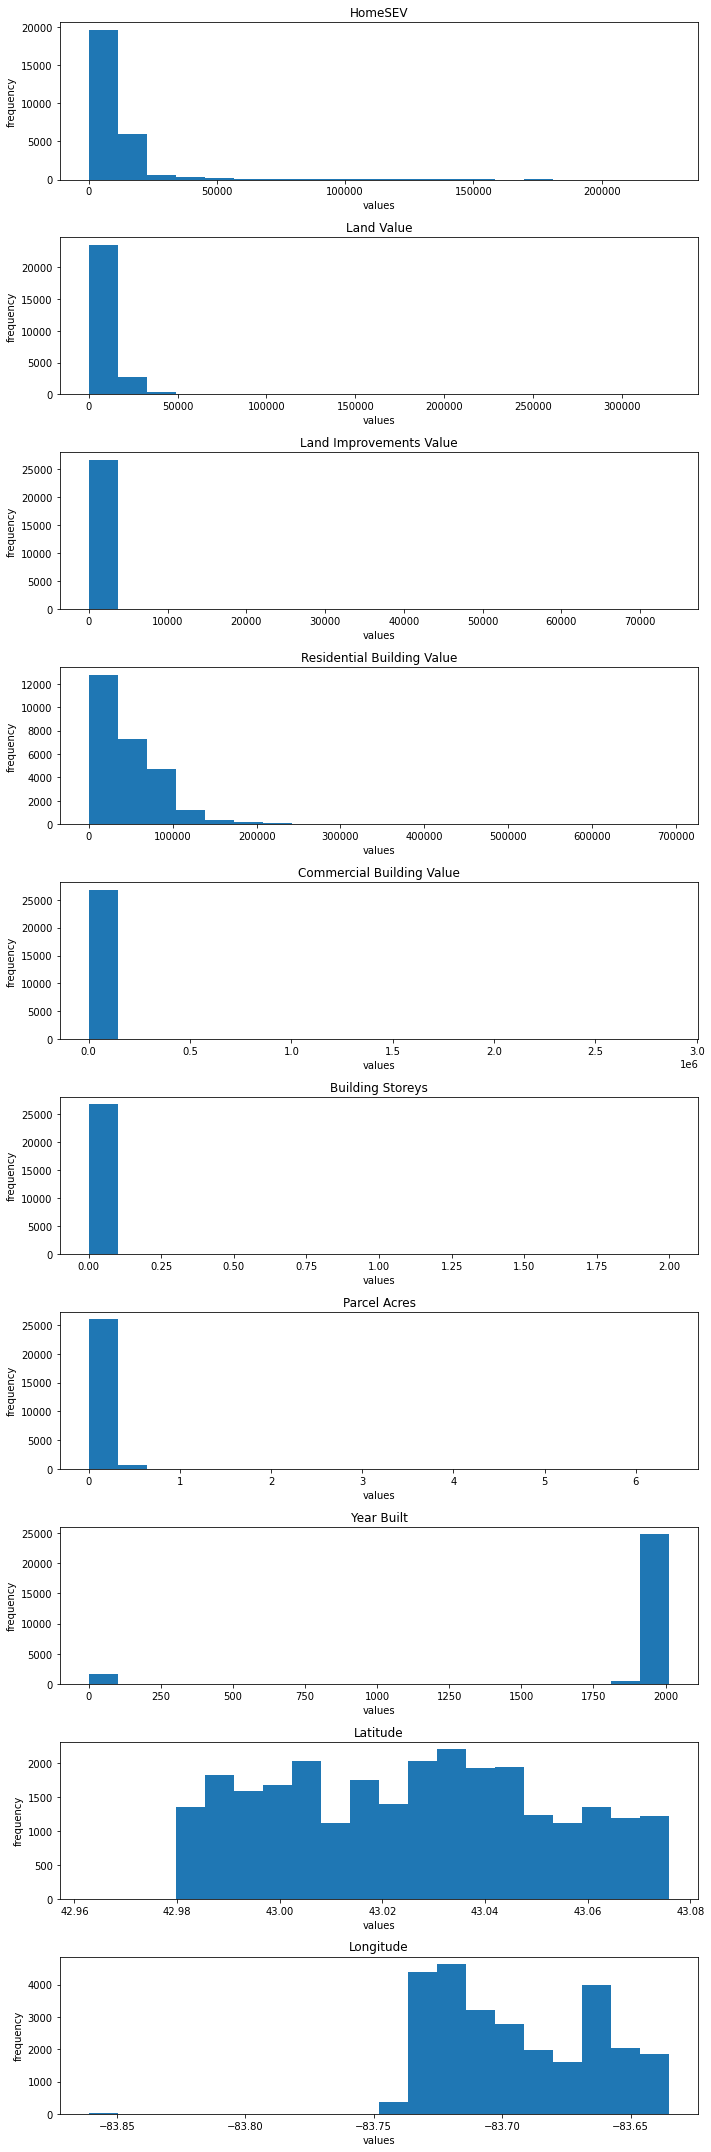

In [ ]:
#plot univariate histograpms
fig, ax = plt.subplots(len(quant_features), 1, figsize=(10, 30))

for i, feature_name in enumerate(quant_features):
    ax[i].hist(Xdata[feature_name], bins=20)
    ax[i].set_title(feature_name)
    ax[i].set_xlabel('values') # set the x-axis label
    ax[i].set_ylabel('frequency') # set the y-axis label

plt.tight_layout()
plt.show()

As expected, variables that measure value and size are right-skewed (there will inevitably be some outlier very large and very expensive properties). 

Interestingly, the parcels are pretty uniformly distributed over Latitude but not over Longitude. So, there must be some east-west division built into the structure of the city.

As we noticed before, there are some nonsensically small values for "Year Built." Let's explore this a little bit further. First, we will visualize year built without the small values. Then, we will explore what other home features the nonsensical values may be associated with:

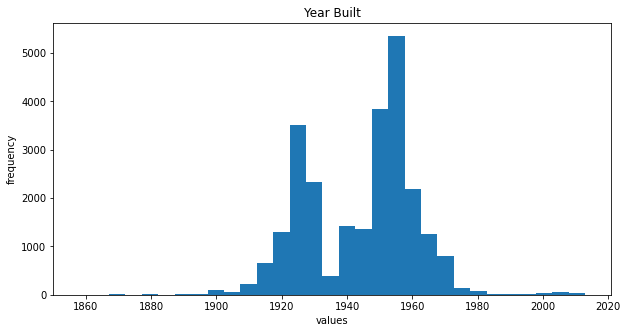

In [ ]:
## Visualize year built over sensical values
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.hist(Xdata['Year Built'], bins=400)
ax.set_title('Year Built')
ax.set_xlabel('values') # set the x-axis label
ax.set_ylabel('frequency') # set the y-axis label
ax.set_xlim(1850,2021)

plt.show()

Year built appears to be somewhat bimodal. This is likely due to historical circumstances, such as a lower amount of homes built during the Great Depression (1930s) and with a boom after the second world war (1950s). It may end up being the case that these two eras (pre Depression, post WW2) are fairly predictive of dangerous pipes. To test this theory, let's find the rate of dangerous pipes within both eras:

In [ ]:
## Comparing dangerous pipes in built eras

indeces_pre_depression = (Xdata['Year Built'] > 1890) & (Xdata['Year Built'] < 1930)
indeces_post_war = (Xdata['Year Built'] > 1945) & (Xdata['Year Built'] < 1960)

print('Proportion of Pre Depression homes dangerous: ', np.round(np.mean(Ydata[indeces_pre_depression].dangerous == '1'),3))
print('Proportion of Post WW2 homes dangerous: ', np.round(np.mean(Ydata[indeces_post_war].dangerous == '1'),3))

Proportion of Pre Depression homes dangerous:  0.885
Proportion of Post WW2 homes dangerous:  0.072


It's clear that pre-Depression homes have much higher incidence of dangerous material than Post WW2 homes. Dividing year built in this way provides an amazingly strong predictors of the dangers of lead. This shows why year built is such a strong predictor in their model.

Now, let's see if we can figure out why the homes with nonsensically low "year built" values have such low values. 

In [ ]:
#select just the rows with very small "year built" and describe the dataframe
Xdata[Xdata['Year Built'] < 1000].describe()

,index,pid,Property Zip Code,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,Residential Building Value,Commercial Building Value,Building Storeys,...,B_single_mothers_w_children,B_households_w_elderly,B_househod_no_elderly,B_aggregate_income,B_speak_spanish,B_speak_only_english,B_no_english,B_hispanic_household,B_imputed_rent,B_imputed_value
count,1629.000000,1.629000e+03,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1.629000e+03,1629.000000,...,1629.000000,1629.000000,1629.000000,1.468000e+03,1629.000000,1629.00000,1629.000000,1567.000000,1567.000000,1567.000000
mean,27736.451197,4.150280e+09,48504.877839,73.108656,3910.523634,2983.436464,185.476980,33314.748926,8.185862e+03,0.063843,...,56.118478,97.154082,233.162676,7.546283e+06,8.971762,494.14733,0.001228,26.357371,143.333759,177.777920
std,14859.521366,2.219361e+08,3.377070,44.067863,8060.812598,5570.996050,1166.616404,28395.171631,8.082498e+04,0.316772,...,49.952915,54.340418,116.763074,7.515321e+06,14.308481,241.27362,0.049553,22.144075,69.015511,106.855941
min,38.000000,4.001106e+09,48502.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,8.000000,13.000000,-1.000000e+00,0.000000,82.00000,0.000000,0.000000,0.000000,0.000000
25%,15631.000000,4.014333e+09,48503.000000,0.000000,0.000000,612.000000,0.000000,11049.000000,0.000000e+00,0.000000,...,17.000000,63.000000,145.000000,1.628100e+06,0.000000,321.00000,0.000000,11.000000,99.000000,97.000000
50%,28480.000000,4.105378e+09,48505.000000,100.000000,0.000000,1336.000000,0.000000,25218.000000,0.000000e+00,0.000000,...,47.000000,95.000000,209.000000,6.230100e+06,0.000000,446.00000,0.000000,18.000000,132.000000,153.000000
75%,39704.000000,4.119357e+09,48506.000000,100.000000,6400.000000,2899.000000,0.000000,49668.000000,0.000000e+00,0.000000,...,78.000000,112.000000,299.000000,9.973500e+06,15.000000,622.00000,0.000000,36.000000,169.000000,232.000000
max,55150.000000,4.733453e+09,48532.000000,100.000000,226400.000000,88413.000000,18891.000000,219343.000000,2.864489e+06,2.000000,...,233.000000,325.000000,506.000000,4.073730e+07,74.000000,1091.00000,2.000000,106.000000,452.000000,435.000000


I cannot find any unusual patterns in the parcels that represent the homes with nonsensical "year built." This is an area for further exploration.

#### Categorical Data Exploration

Let's visualize the distributiosn of categorical features using bar chrats

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


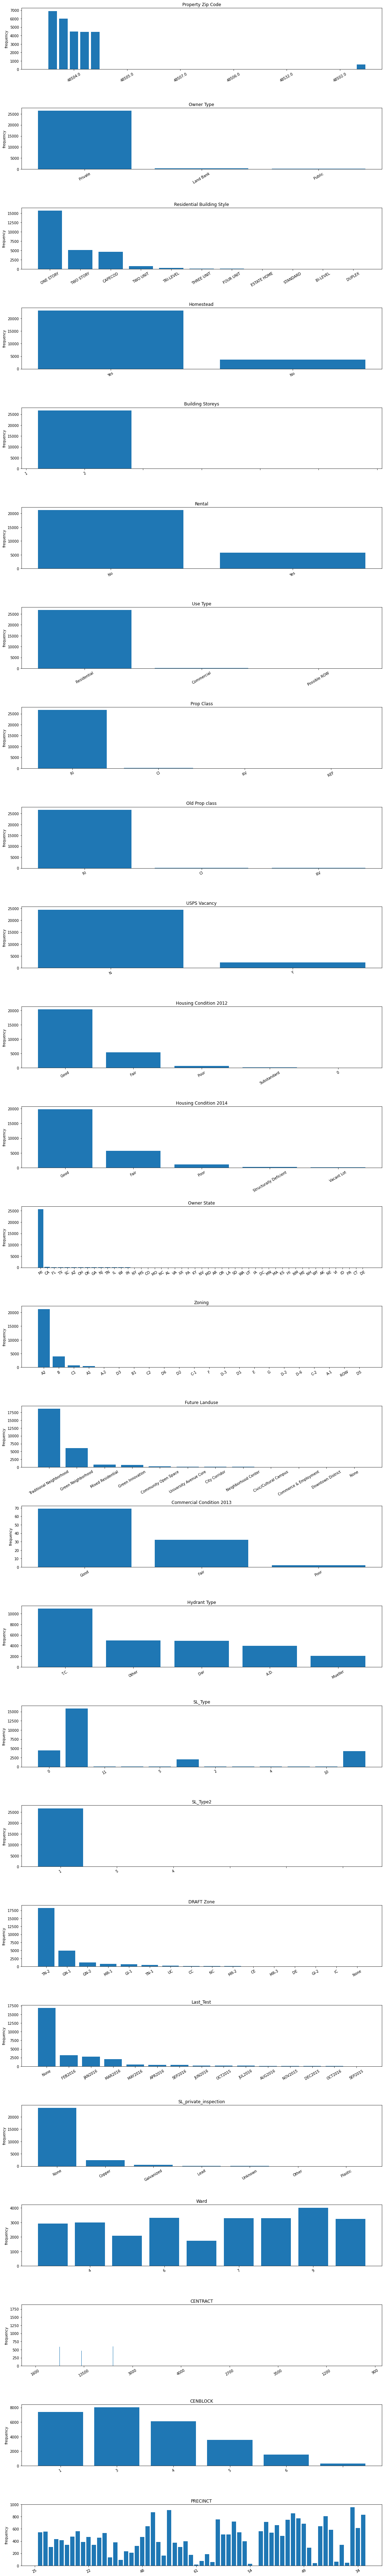

In [ ]:
# columns made into dummies during training
dummy_cols = ['Property Zip Code', 'Owner Type', 'Residential Building Style', 'Homestead', 'Building Storeys',
              'Rental', 'Use Type', 'Prop Class', 'Old Prop class', 'USPS Vacancy', 'Housing Condition 2012',
              'Housing Condition 2014', 'Owner State', 'Zoning', 'Future Landuse', 'Commercial Condition 2013',
              'Hydrant Type', 'SL_Type', 'SL_Type2', 'DRAFT Zone', 'Last_Test', 'SL_private_inspection', 'Ward',
              'CENTRACT', 'CENBLOCK', 'PRECINCT']


#plot univariate histograpms
fig, ax = plt.subplots(len(dummy_cols), 1, figsize=(15, 100))

for i, feature_name in enumerate(dummy_cols):
    ax[i].bar(Xdata[feature_name].value_counts().index, height = Xdata[feature_name].value_counts().values)
    ax[i].set_title(feature_name)
    ax[i].set_ylabel('frequency') # set the y-axis label
    ax[i].set_xticklabels(Xdata[feature_name].value_counts().index, rotation=30)

plt.tight_layout()
plt.show()

**Question For Jared:** What is "Possible ROW" data value for the "Use Type" variable?

Since Jared mentioned this on our call, let's see how strong a predictor hydrant type is for the presence of dangerous pipes:

In [ ]:
## proportion of homes with dangerous pipes, based on type of hydrant
for hydrant_type in np.unique(Xdata['Hydrant Type']):
    print('Proportion of homes dangerous with a ',hydrant_type, 'hydrant: ', np.round(np.mean(Ydata[Xdata['Hydrant Type']==hydrant_type].dangerous == '1'),3))

Proportion of homes dangerous with a  A.D. hydrant:  0.434
Proportion of homes dangerous with a  Dar hydrant:  0.64
Proportion of homes dangerous with a  Mueller hydrant:  0.384
Proportion of homes dangerous with a  Other hydrant:  0.515
Proportion of homes dangerous with a  T.C. hydrant:  0.188


Not nearly as strong of a predictor as year built, but there are some associations.

### Geographic Exploration

Finally, let's visualize the homes that have dangerous pipes on a full map of the city.

In [ ]:
flint = gpd.read_file('flint_sl_materials/flint_sl_materials.shp')

In [ ]:
#Add colors based on dangerous pipes
flint['colors'] = ['#FF0000' if x == '1' else '#0070C0' for x in flint.dangerous.values]

Text(0.5, 1.0, 'Flint, Dangerous Pipe Parcels in Red')

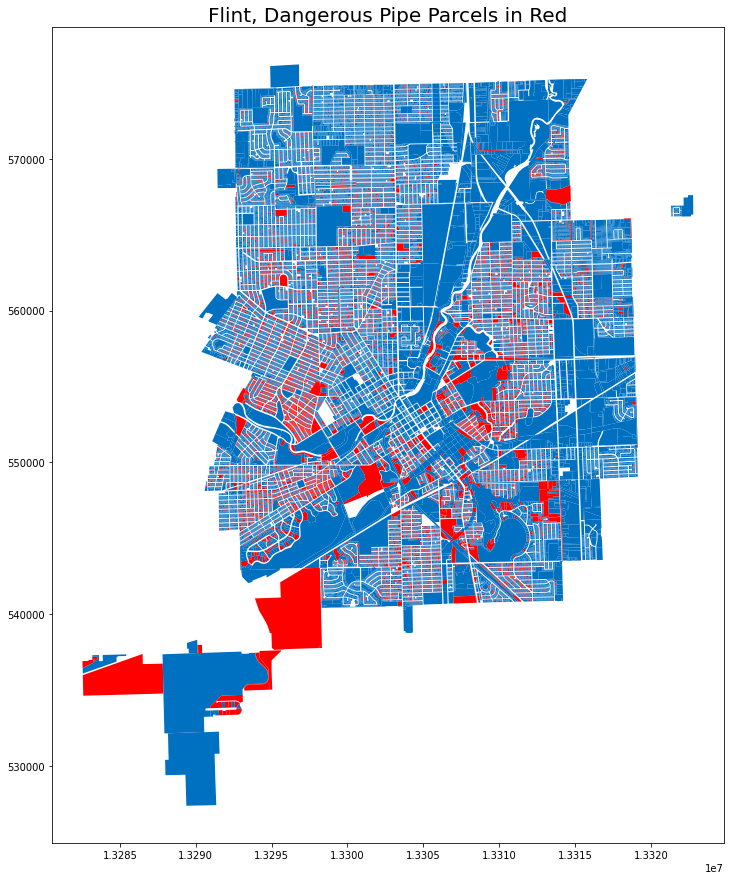

In [ ]:
#Visualize with color red for dangerous pipes
flint.plot(figsize = (15,15), color = flint['colors'])
plt.title('Flint, Dangerous Pipe Parcels in Red', fontdict = {'fontsize': 20})

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0454e361-723e-4e4e-b47c-ac12a84863d5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>